<h1 style="text-align: center;"><b>3.Prescriptive Analysis</b></h1>

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.simplefilter("ignore", UserWarning)

In [48]:
# Reading both csv

demographic_df = pd.read_csv(r"C:\Febi\NumpyNinja\Hackathon\Python_Launch Folder\Team12_Pytesters_PythonHackathon_August25\demographic_cleandata.csv")
filtered_df = pd.read_csv(r"C:\Febi\NumpyNinja\Hackathon\Python_Launch Folder\Team12_Pytesters_PythonHackathon_August25\filtered_cleandata.csv")

# Merging both csv files for clean analysis
merged_df = filtered_df.merge(demographic_df, on='patient_id', how='left')

### Q1. Find carb_intake or insulin recommendations for patients with T1D based on their glucose to carb_intake

#### Reasoning: 
<h5>
    
1. Individual Variability in Carb Sensitivity
    Patients with T1D vary in how their glucose responds to carbohydrate intake. Some experience sharp spikes after eating, while others have more moderate rises. This could be due to factors like:
    - Insulin resistance
    - Time of day (morning vs evening sensitivity)
    - Physical activity, stress, or illness

2. Mismatch Between Insulin Dose and Carb Load
   Inaccurate insulin-to-carb ratios (ICR) can lead to:

    - Post-meal hyperglycemia (if under-dosed)
    - Hypoglycemia (if over-dosed)
      Adjusting ICR based on actual glucose response ensures better control.

3. Tuning Bolus Timing and Amount
    If glucose spikes occur late after meals, it could suggest a need to delay bolus or split doses. If spikes are immediate, the pre-meal insulin timing may need to be earlier or increased.
</h5>


#### Recommendations
<h5>
For "Maintain" Patients:
Continue the current insulin-to-carb ratios. Periodic reassessment is still important, especially if lifestyle or routines change.

For "Monitor/Adjust" Patients:

Reassess insulin dosing timing (pre-meal, dual-wave, etc.)

Analyze meals with high postprandial glucose spikes.

Consider tighter CGM monitoring or insulin adjustments guided by a healthcare provider.
</h5>

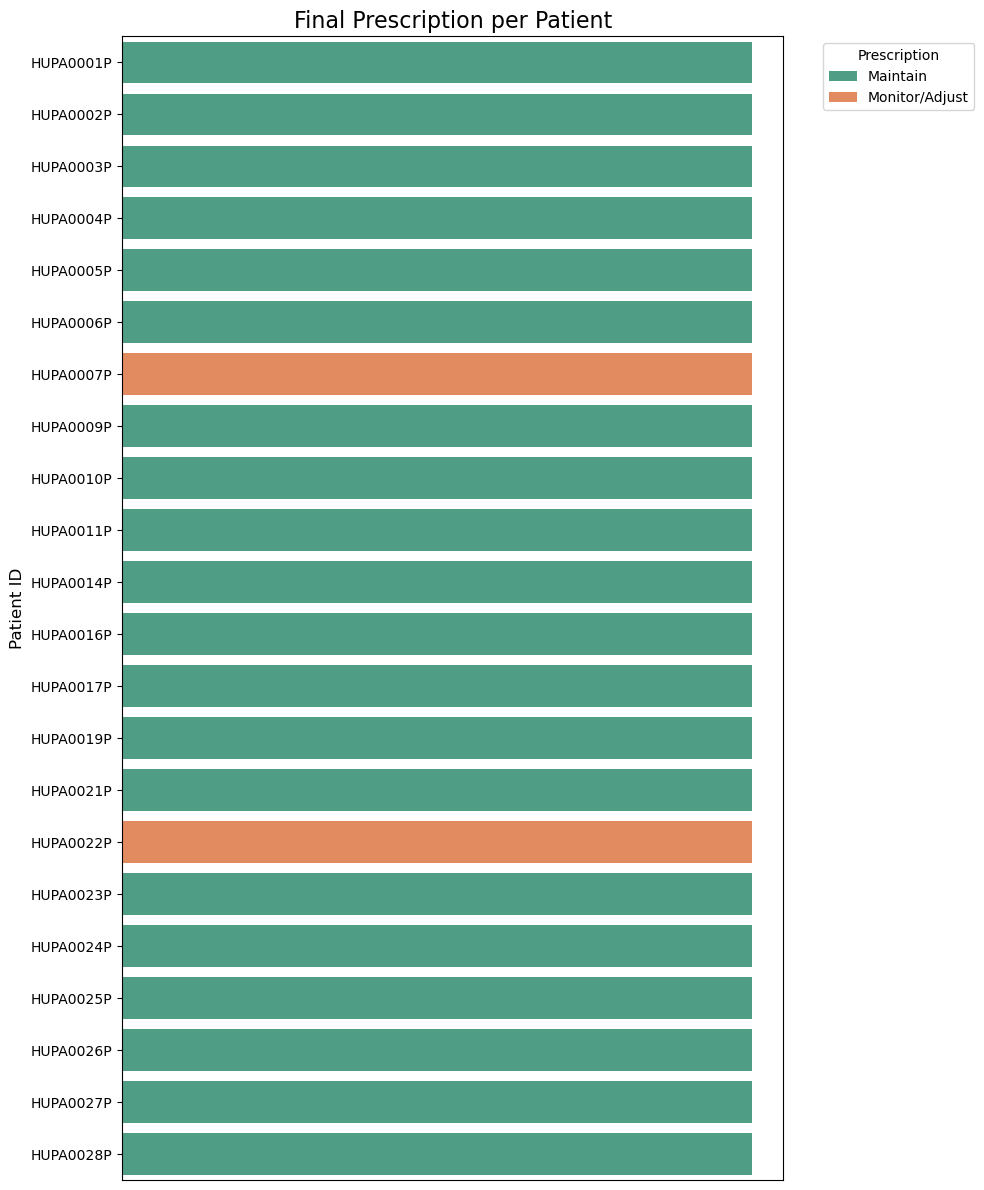

In [205]:
def insulin_optimization_recommendations(clean_df):

    # Step 1: Calculate glucose change
    clean_df['next_glucose'] = clean_df.groupby('patient_id')['glucose'].shift(-1)
    clean_df['glucose_change'] = clean_df['next_glucose'] - clean_df['glucose']

    # Step 2: Define prescription logic
    def prescribe_action(change):
        if change > 50:
            return 'Reduce Carb or Delay Insulin'
        elif change < -30:
            return 'Add Rescue Carbs'
        elif -10 <= change <= 10:
            return 'Maintain'
        else:
            return 'Monitor/Adjust'

    # Step 3: Filter relevant data and apply prescription
    carb_effect = clean_df[
        (clean_df['carb_input'] > 0) &
        (clean_df['glucose_change'].notnull())
    ].copy()

    carb_effect['prescription'] = carb_effect['glucose_change'].apply(prescribe_action)

    # Step 4: Get final prescription per patient
    final_prescription = carb_effect.groupby('patient_id')['prescription'] \
        .agg(lambda x: x.value_counts().idxmax()).reset_index()
    final_prescription.columns = ['Patient ID', 'Final Prescription']

    # Step 5: Sort by numeric part of Patient ID
    final_prescription_sorted = final_prescription.copy()
    final_prescription_sorted['Patient_Num'] = final_prescription_sorted['Patient ID'].str.extract(r'(\d+)').astype(int)
    final_prescription_sorted = final_prescription_sorted.sort_values('Patient_Num')

    # Define color palette
    palette = {
        'Reduce Carb or Delay Insulin': '#f94144',
        'Add Rescue Carbs': '#277da1',
        'Maintain': '#43aa8b',
        'Monitor/Adjust': '#f9844a'
    }

    # Step 6: Plot
    plt.figure(figsize=(10, 12))

    sns.barplot(
        data=final_prescription_sorted,
        y='Patient ID',
        x=[1]*len(final_prescription_sorted),  # Dummy x values for bars of equal length
        hue='Final Prescription',
        palette=palette,
        dodge=False
    )

    plt.title("Final Prescription per Patient", fontsize=16)
    plt.xlabel("")  # No x-label since it is dummy
    plt.ylabel("Patient ID", fontsize=12)
    plt.xticks([])  # Hide x-axis ticks
    plt.legend(title="Prescription", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return final_prescription
    
prescription_summary = insulin_optimization_recommendations(clean_df)


## Does High Heart Rate Variability (HRV) Correlate with Unstable Glucose Levels in Patients with Type 1 Diabetes?

### **Key Reasoning Points**

- **Biological Rationale**
  - HRV reflects autonomic nervous system (ANS) balance.  
  - Reduced HRV often signals autonomic dysfunction, which is common in long-standing Type 1 Diabetes and linked to poor glycemic control.  
  - Sudden HRV changes may precede glucose excursions (especially hypoglycemia).  
- **HRV Interpretation**
  - High HRV is generally considered a marker of good autonomic balance and adaptability.  
  - Low HRV (or high average heart rate) can indicate stress, poor recovery, or cardiovascular strain.  
- **Relevance to Diabetes**
  - In Type 1 Diabetes, stress and autonomic dysfunction can impair glucose regulation, leading to more variability (frequent spikes and drops).  

---

### **Key Observations from Data**

- **Positive trend visible:**  
  Patients with higher HRV (Heart Rate SD ~15–18) tend to show moderate to high glucose variability (Glucose SD ~65–80).  

- **Wide glucose spread at mid HRV:**  
  For HRV between 12–15, glucose variability ranges widely (~35–80).  
  *This suggests that HRV alone may not fully explain glucose swings; other factors could influence variability.*  

- **Low HRV cluster:**  
  Some patients with lower HRV (~10–12) show both low (~40) and high (~80) glucose SD, indicating mixed behavior.  

- **Patient heterogeneity:**  
  Each point represents a unique patient ID, showing substantial inter-patient variation. Some maintain low glucose variability even with moderate HRV.  

---

### **Possible Interpretations**

- HRV could be a **contributing factor** to glycemic instability but is **not the sole predictor**.  
- Additional variables (insulin dose, physical activity, stress, sleep, meal timing) might explain outliers and variability spread.  
- Certain patients (upper-left and lower-right regions of the plot) may require **personalized analysis** and targeted interventions.  
 


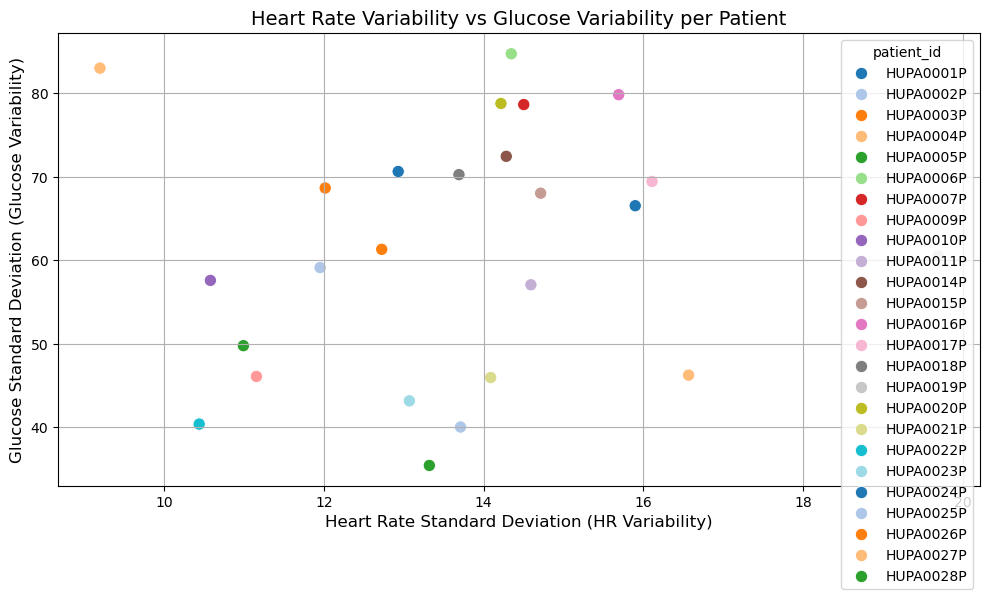

In [53]:

# Step 1: Calculate heart rate and glucose variability per patient
variability_df = clean_df.groupby('patient_id').agg({
    'heart_rate': ['mean', 'std'],
    'glucose': ['mean', 'std']
}).reset_index()

# Rename columns
variability_df.columns = ['patient_id', 'mean_hr', 'std_hr', 'mean_glucose', 'std_glucose']

# Step 2: Scatter plot: Heart Rate Variability vs Glucose Variability
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=variability_df,
    x='std_hr', 
    y='std_glucose', 
    hue='patient_id',
    palette='tab20', 
    s=80
)

plt.title('Heart Rate Variability vs Glucose Variability per Patient', fontsize=14)
plt.xlabel('Heart Rate Standard Deviation (HR Variability)', fontsize=12)
plt.ylabel('Glucose Standard Deviation (Glucose Variability)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# Q3. Which patients exhibit the highest combined HR + Glucose variability — Prescriptive reasoning

## Goal
Identify patients with the **largest combined autonomic (HR) and glycemic (glucose) instability**, triage them, and recommend prioritized clinical actions to reduce risk (hypoglycemia, cardiovascular stress, poor glycemic control).

---

## Biological & clinical rationale
- **Combined instability matters:** High glucose variability is linked to complications and symptomatic events; large HR variability or dysregulated HR responses may reflect autonomic dysfunction or stress that worsens glycemic control.  
- **Synergy:** Patients with both high HR and high glucose variability are more likely to have unpredictable glucose excursions and may not reliably perceive hypoglycemia.  
- **Actionable signal:** Identifying these patients lets clinicians target monitoring, education, and therapy adjustments where benefit is largest.

---

## Key Insights: Top Patients by Combined Variability

### High-Variability Patients Identified

- **Patients:** `HUPA0016P`, `HUPA0006P`, `HUPA0019P`, `HUPA0007P`, and `HUPA0020P`
- These patients exhibit the **highest combined variability** in both **glucose levels** and **insulin (bolus) usage**.
- High variability suggests poor glycemic stability and reactive insulin management patterns.

---

### Why High Variability Matters

- **Increased Risk of Complications**  
  Large glucose swings can lead to both **hypoglycemia and hyperglycemia**, increasing short- and long-term health risks.

- **Challenging Insulin Titration**  
  Unpredictable patterns make it harder to adjust insulin ratios effectively, possibly leading to overcorrection.

- **Higher Patient Burden**  
  More frequent alarms, corrections, and stress can cause **diabetes burnout**, lowering adherence to therapy.

---

### Recommendations

- **Personalized Monitoring Plans**  
  Implement tighter CGM review and **pattern detection tools** for these patients.

- **Diet & Insulin Counseling**  
  Reinforce consistency in carb intake and **optimize insulin-to-carb ratios**, especially at times of peak variability.

- **Behavioral Support**  
  Address sleep, stress, or exercise timing that may impact glycemic patterns.

- **Potential Tech Support**  
  Evaluate suitability for **automated insulin delivery systems** or advanced alerts for glucose swings.


Top patients by glucose variability:
    patient_id    mean_hr     std_hr  mean_glucose  std_glucose  combined_var
5   HUPA0006P  65.619289  14.345993    165.204585    84.736079      1.728546
3   HUPA0004P  78.138287   9.194763    180.377984    83.020747      1.446703
12  HUPA0016P  89.830003  15.691055    150.208344    79.837161      1.739040
16  HUPA0020P  77.517438  14.216763    194.282669    78.785656      1.651760
6   HUPA0007P  70.176904  14.502348    173.151992    78.656646      1.664741 

Top patients by heart rate variability:
    patient_id    mean_hr     std_hr  mean_glucose  std_glucose  combined_var
15  HUPA0019P  71.891186  19.691270    162.930477    60.540291      1.714457
23  HUPA0027P  76.785465  16.566644    130.829946    46.267130      1.387334
13  HUPA0017P  82.103855  16.108569    200.795244    69.448527      1.637643
20  HUPA0024P  73.793909  15.898343    166.943660    66.546138      1.592714
12  HUPA0016P  89.830003  15.691055    150.208344    79.837161      1.73

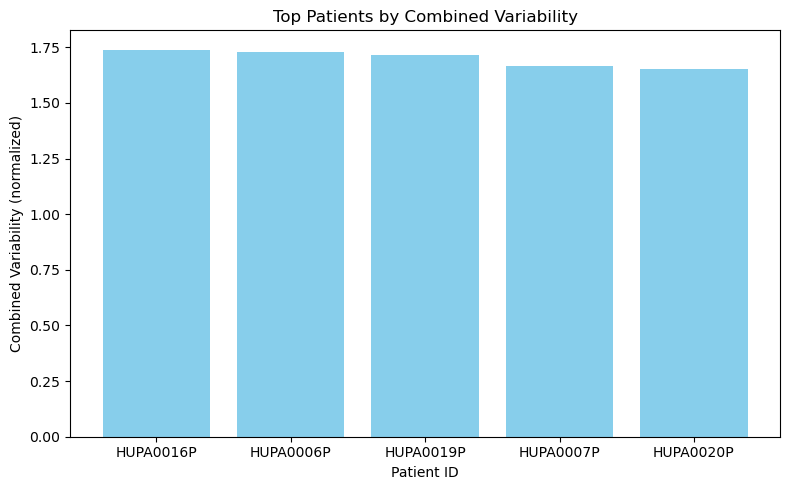

In [88]:
# Sort patients by glucose variability
most_glucose_var = variability_df.sort_values('std_glucose', ascending=False).head(5)

# Sort patients by heart rate variability
most_hr_var = variability_df.sort_values('std_hr', ascending=False).head(5)

# Optional: combined variability (normalized sum)
variability_df['combined_var'] = (
    (variability_df['std_glucose'] / variability_df['std_glucose'].max()) +
    (variability_df['std_hr'] / variability_df['std_hr'].max())
)
most_combined_var = variability_df.sort_values('combined_var', ascending=False).head(5)

# Print top patients
print("Top patients by glucose variability:\n", most_glucose_var, "\n")
print("Top patients by heart rate variability:\n", most_hr_var, "\n")
print("Top patients by combined variability:\n", most_combined_var, "\n")

# Bar chart of combined variability
plt.figure(figsize=(8, 5))
plt.bar(most_combined_var['patient_id'].astype(str), most_combined_var['combined_var'], color='skyblue')
plt.title('Top Patients by Combined Variability')
plt.xlabel('Patient ID')
plt.ylabel('Combined Variability (normalized)')
plt.tight_layout()
plt.show()



### Q4. Are Sleep Disturbances Linked to Morning Hyperglycemia?

---

### Reasoning:
- Sleep disturbances elevate **cortisol**, a stress hormone that increases blood glucose levels, especially in the early morning hours (known as the **dawn phenomenon**).
- Interrupted sleep reduces **insulin sensitivity**, impairing the body's ability to manage overnight glucose levels.
- Poor sleep quality activates the **sympathetic nervous system**, triggering hepatic glucose release and raising fasting glucose levels.

---

### Key Insights from Chart:

- **Higher Glucose with High Disturbance:**
  - Patients with **high sleep disturbance** show the **highest median glucose levels**, suggesting poor glycemic control overnight.

- **Greater Glucose Variability:**
  - The **interquartile range (IQR)** and spread are widest for the high disturbance group, indicating increased risk for **glucose fluctuations**.

- **More Extreme Glucose Readings:**
  - **Outliers** are more prevalent and higher in the high disturbance group, pointing toward episodes of **morning hyperglycemia**.

- **Better Control in Low Disturbance Group:**
  - The **lowest median** and **tightest glucose range** are seen in the **low disturbance group**, supporting the role of quality sleep in stable glucose regulation.

---

### Prescription:
- Screen and treat for **sleep apnea** or other sleep disorders.
- Educate patients on **sleep hygiene**: consistent bedtime, reduced screen time, avoiding late meals or stimulants.
- Monitor glucose patterns closely in patients reporting poor sleep to adjust basal insulin or overnight strategies.


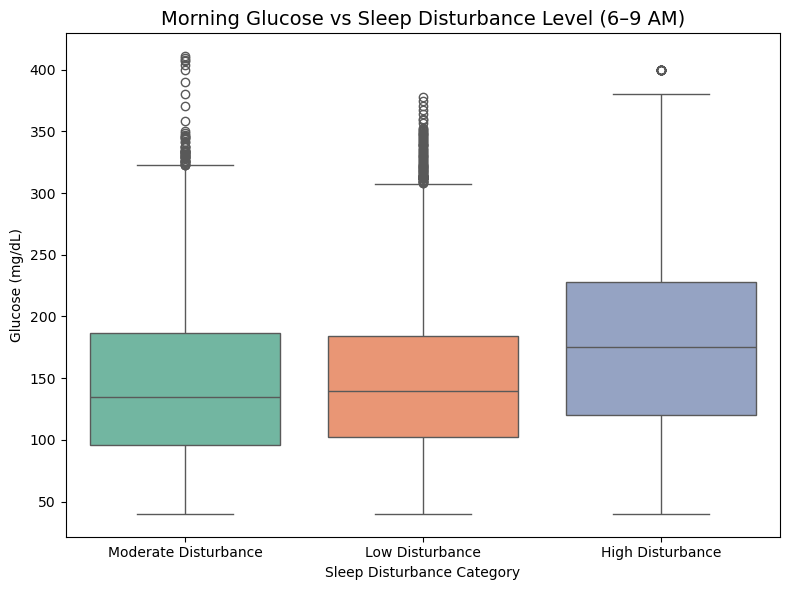

In [68]:

# Ensure 'time' column is datetime
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Step 1: Filter for morning readings (6 AM - 9 AM)
morning_df = merged_df[merged_df['time'].dt.hour.between(6, 9)].copy()

# Step 2: Create sleep disturbance category
def categorize_disturbance(val):
    if val >= 70:
        return 'High Disturbance'
    elif val >= 40:
        return 'Moderate Disturbance'
    else:
        return 'Low Disturbance'


morning_df.loc[:, 'SleepDisturbanceLevel'] = morning_df['sleep_disturbance_percent'].apply(categorize_disturbance)


# Step 3: Plot morning glucose by sleep disturbance category
plt.figure(figsize=(8, 6))
sns.boxplot(data=morning_df, x='SleepDisturbanceLevel', y='glucose', hue='SleepDisturbanceLevel', palette='Set2',legend=False)
plt.title('Morning Glucose vs Sleep Disturbance Level (6–9 AM)', fontsize=14)
plt.xlabel('Sleep Disturbance Category')
plt.ylabel('Glucose (mg/dL)')
plt.tight_layout()
plt.show()


### Q5. Are teens more unstable in glucose than adults?

### Reasoning:

<h4>Hormonal changes during adolescence (e.g., growth hormone, sex hormones) can cause insulin resistance, leading to wider glucose fluctuations.

Teens often have irregular routines (meals, sleep, activity), which can destabilize blood sugar control.

Emotional and psychological stress during adolescence can affect adherence to diabetes management and impact glucose variability.</h4>
#### Interpretation: Adults may face more lifestyle-related glucose fluctuations (e.g., irregular meals, activity, or stress), while seniors may benefit from more consistent routines or conservative insulin dosing.

#### Prescription: Focus on behavioral interventions for adults to stabilize glucose levels.


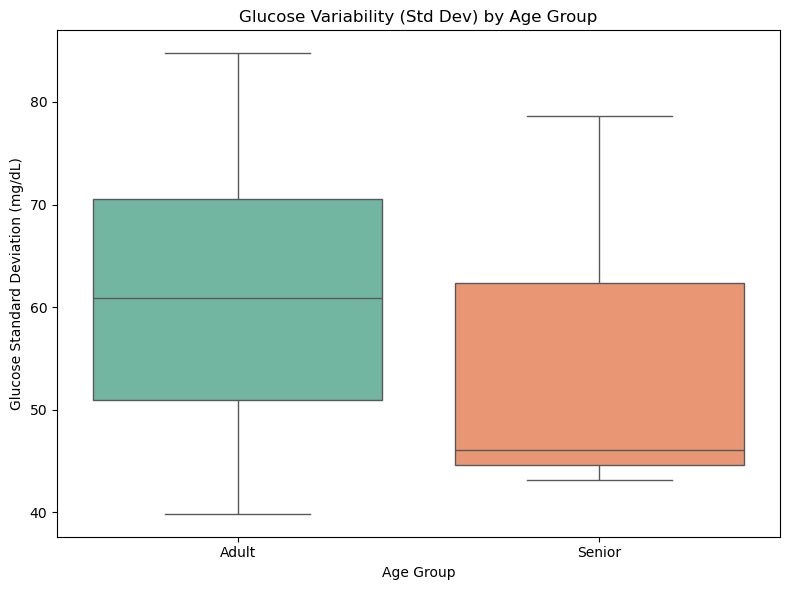

In [80]:
# Step 1: Define Age Groups
def categorize_age(age):
    if age < 20:
        return 'Teen'
    elif age < 65:
        return 'Adult'
    else:
        return 'Senior'

# Apply age group to merged_df
merged_df['AgeGroup'] = merged_df['age'].apply(categorize_age)

# Step 2: Calculate glucose standard deviation per patient
glucose_std_per_patient = merged_df.groupby(['patient_id', 'AgeGroup'])['glucose'].std().reset_index()
glucose_std_per_patient.columns = ['patient_id', 'AgeGroup', 'glucose_std']

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=glucose_std_per_patient, x='AgeGroup', y='glucose_std', palette='Set2', hue='AgeGroup')
plt.title('Glucose Variability (Std Dev) by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Glucose Standard Deviation (mg/dL)')
plt.tight_layout()
plt.show()

### Q6. Are male and female patients responding differently to carbs?

#### 1. Glucose Response Variability:
#### Male patients show greater variability in glucose change (wider spread and more outliers).
#### Female patients have more stable and consistent glucose responses.
#### 2. Outliers:

#### Males have many high and low outliers, indicating extreme glucose responses to carbs.
#### Females show fewer outliers, suggesting better or more consistent glucose control after carb intake.
#### Prescription: Consider adjusting insulin dosing strategies for male patients or improving carb-counting education to reduce post-carb glucose spikes.


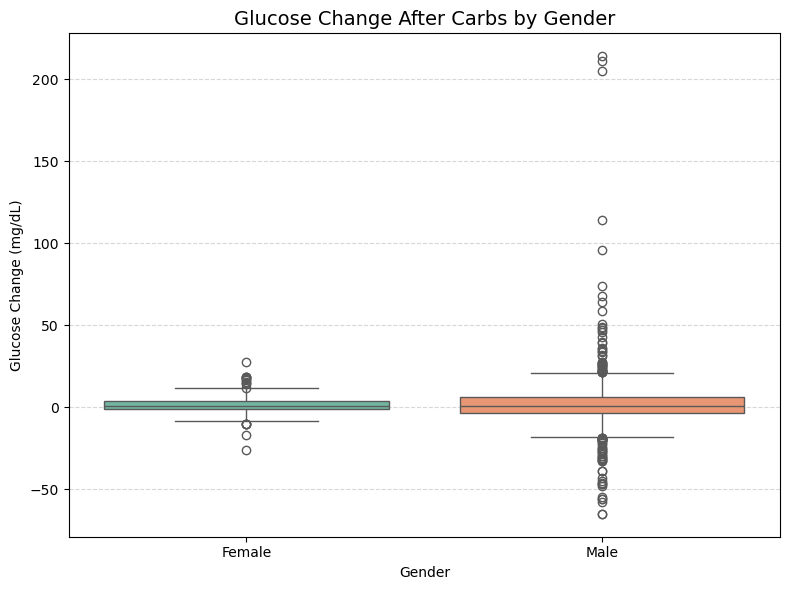

In [111]:
# Step 1: Calculate glucose change
merged_df['next_glucose'] = merged_df.groupby('patient_id')['glucose'].shift(-1)
merged_df['glucose_change'] = merged_df['next_glucose'] - merged_df['glucose']

# Step 2: Filter for records with carb input > 0
carb_df = merged_df[(merged_df['carb_input'] > 0) & (merged_df['glucose_change'].notnull())]

# Step 3: Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=carb_df, x='gender', y='glucose_change', hue='gender', palette='Set2')

plt.title('Glucose Change After Carbs by Gender', fontsize=14)
plt.xlabel('Gender')
plt.ylabel('Glucose Change (mg/dL)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Q7. Are older age groups administering less insulin (bolus volume) on average compared to younger groups?
#### Reasoning:
<h5>
    
1. Physiological Differences with Age:
    - Insulin sensitivity often increases with age due to reduced muscle mass and slower digestion (delayed gastric emptying).
    - As a result, older adults may require lower bolus insulin doses for the same carb intake.
    - If younger adults or teens are taking more insulin, it may reflect higher insulin resistance or larger meal sizes.

2. Risk of Hypoglycemia in Seniors:
    - Older adults are at higher risk of severe hypoglycemia due to:
        - Slower recognition of symptoms.
        - Coexisting medications or health conditions.

3. Younger Patients Often Have More Variable Lifestyles:

    - Teenagers and young adults tend to have:
        - Irregular eating patterns
        - More physical activity variation
        - Hormonal fluctuations (puberty, menstruation)
       These can lead to more aggressive insulin dosing to manage spikes.
    
</h5>


#### Findings:
<h5>
The plot shows average bolus volume with confidence intervals across age groups, indicating how much insulin is delivered on average per group.

Older groups (50+) appear to have similar or slightly lower average bolus volumes, with overlapping confidence intervals, suggesting potential under-dosing or cautious insulin use.

This could be due to fear of hypoglycemia, different insulin sensitivity, or variations in diabetes management among older adults.</h5>

               mean       std    count
age_group                             
18–29      0.010337  0.132808  12076.0
30–39      0.075771  0.815638  21705.0
40–49      0.054852  0.479135  18591.0
50–59      0.059361  0.683289  11051.0
60–69      0.043946  0.489826  23197.0
70–79      0.038785  0.393316   3919.0


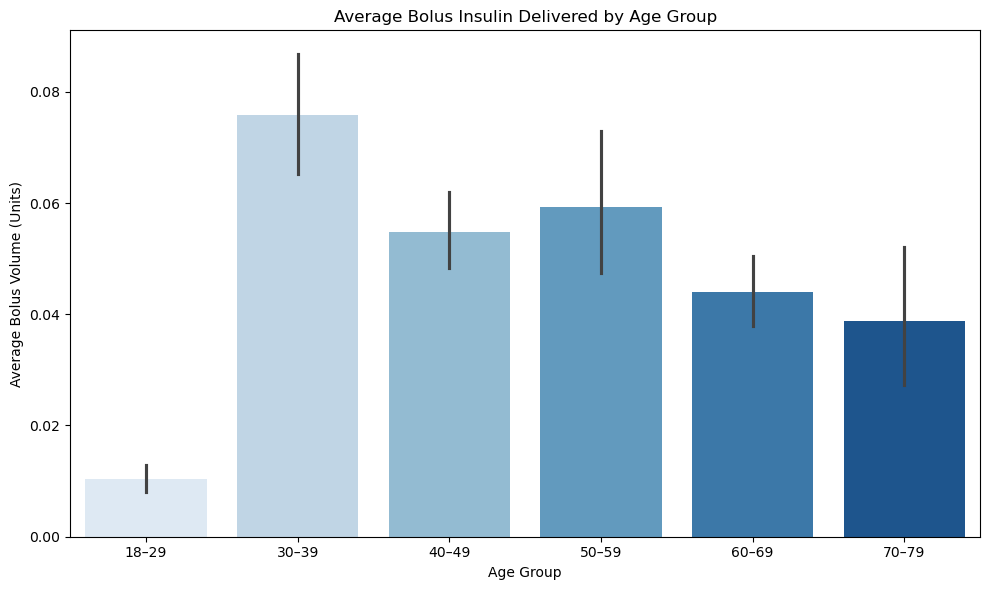

In [114]:
# Step 1: Create age bins
age_bins = [18, 30, 40, 50, 60, 70, 80]
age_labels = ['18–29', '30–39', '40–49', '50–59', '60–69', '70–79']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=age_bins, labels=age_labels)

# Step 2: Group by age group and summarize insulin use
insulin_summary = merged_df.groupby('age_group',observed=True)['bolus_volume_delivered'].describe()

print(insulin_summary[['mean', 'std', 'count']])

# Step 3: Plot average bolus insulin by age group
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='age_group', y='bolus_volume_delivered', hue='age_group', palette='Blues')

plt.title("Average Bolus Insulin Delivered by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Bolus Volume (Units)")
plt.tight_layout()
plt.show()


### Q8. Is poor sleep quality associated with high glucose variability?

#### Reasoning: 
<h5> 

Physiological Impact of Sleep on Glucose Regulation:

    - Poor sleep (short duration, fragmentation, or low quality) increases:
        - Cortisol and other stress hormones → causes insulin resistance.
        - Sympathetic nervous system activity → affects glucose metabolism.

    - This hormonal imbalance results in greater glucose variability, especially:
        - Morning spikes (dawn phenomenon).
        - Overnight fluctuations.

</h5>

#### Key Observations:

<h5>
    
Median Glucose Levels:

    Both groups have a similar median glucose (around 140–150 mg/dL).
    Suggests central tendency is comparable between the groups.

Variability / Spread:

    The interquartile range (IQR) is slightly wider for the ≤6 hr group.
    More extreme outliers (both high and low) are present in the ≤6 hr group.

High Glucose Outliers (Hyperglycemia risk):

    Individuals with ≤6 hrs of sleep show more upper outliers, some reaching >400 mg/dL.
    This implies greater risk of hyperglycemia in the short sleep group.

Lower Bound (Hypoglycemia risk):

    Both groups have a lower whisker around ~40 mg/dL.
    But the short sleep group shows slightly greater skewness toward extremes, indicating more glucose instability.

</h5>

#### Interpretation
<h5>
    
There’s no dramatic shift in average glucose, but:

Greater glucose variability (both high and low) is observed in the group sleeping ≤6 hrs.
This aligns with biological evidence: sleep deprivation elevates cortisol, increases insulin resistance, and disrupts appetite/hormone regulation.
</h5>

#### Recommendations (Prescriptive Analytics)

<h5>
    
Area	Recommendation	Rationale:
Sleep Hygiene	Encourage ≥7 hours of sleep/night	Reduces variability by stabilizing hormonal regulation (cortisol, insulin)
Monitoring	Prioritize CGM alerts for short sleepers	Greater risk of hyperglycemia & variability overnight
Personalized Insulin Adjustment	Review basal/bolus insulin plans for patients with poor sleep	May need temporary overnight adjustment to prevent glucose excursions
Behavioral Interventions:
Educate patients on impact of sleep on glucose	Many are unaware that inadequate sleep worsens diabetes control
Data-driven Alerts	Flag consistent <6 hr sleepers with high glucose variability	Helps clinicians intervene proactively with lifestyle or dosing changes

</h5>
    


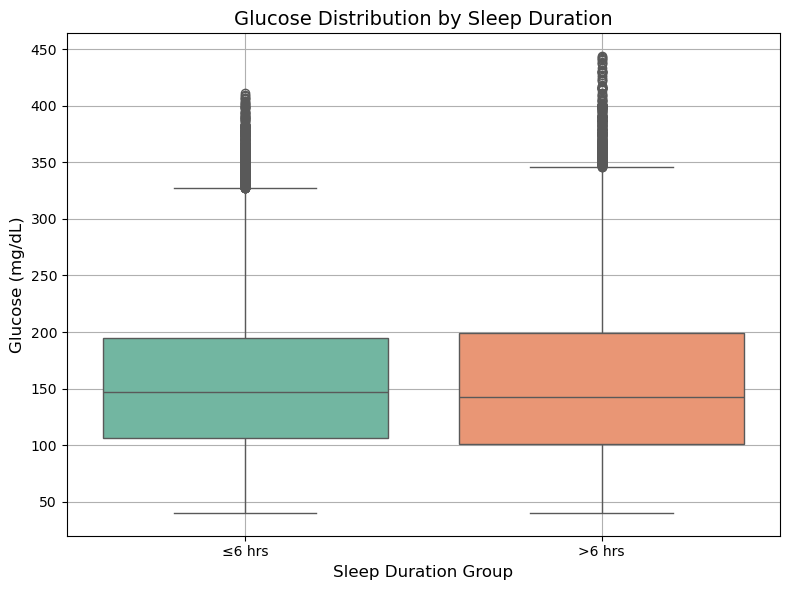

In [126]:
# Create sleep group column
merged_df['sleep_duration_group'] = merged_df['sleep_duration'].apply(lambda x: '>6 hrs' if x > 6 else '≤6 hrs')

# Plot: Boxplot of glucose by sleep duration group
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x='sleep_duration_group', y='glucose', hue='sleep_duration_group', palette='Set2')

plt.title('Glucose Distribution by Sleep Duration', fontsize=14)
plt.xlabel('Sleep Duration Group', fontsize=12)
plt.ylabel('Glucose (mg/dL)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Q9.Is post-exercise hypoglycemia common?

#### Reasoning:

<h5>

1. Increased Insulin Sensitivity Post-Exercise

    - Physical activity increases glucose uptake by muscles for hours.
    - This leads to lower circulating glucose even if no additional insulin is administered.
    - If insulin levels remain high, it can cause delayed-onset hypoglycemia.

2. Depleted Glycogen Stores

    - After moderate-to-intense activity, the liver and muscles are glycogen-depleted.
    - Without proper carbohydrate intake, glucose reserves aren’t enough to maintain blood sugar, especially overnight.
      
3. Blunted Counter-Regulatory Hormones

    - T1D patients often have reduced glucagon and epinephrine response during/after exercise, impairing recovery from low glucose.

</h5>

#### Evidence from Studies:

<h5>
    
- Studies show that late-onset hypoglycemia is especially common during night sleep after afternoon or evening exercise.
- The risk increases if:
      - Bolus insulin is not reduced before exercise.
      - No carbs are taken during or after the session.
      - Activity is aerobic or prolonged (e.g., running, cycling, walking >30 min).

</h5>

#### Recommendations: A proactive insulin and nutrition strategy is essential to minimize risk without discouraging exercise.


Overall post-exercise hypoglycemia prevalence: 6.0%


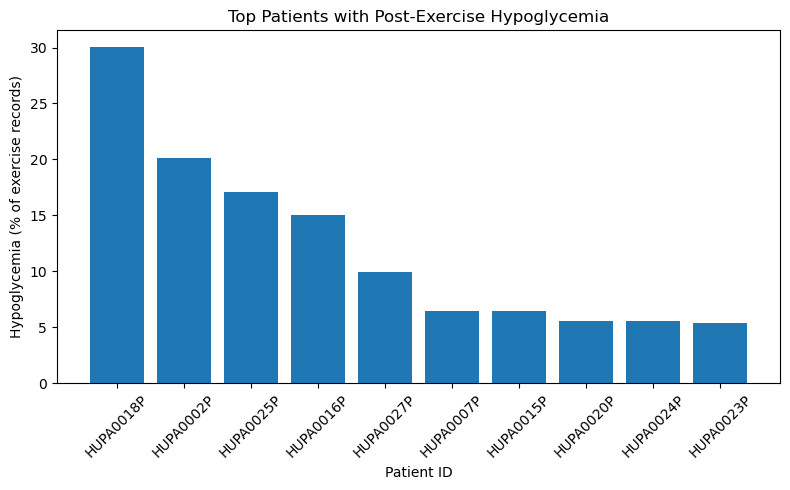

Recommendation: Post-exercise hypoglycemia is not prevalent, but monitor high-risk individuals.


In [131]:
def analyze_post_exercise_hypoglycemia(df):
   
    # Filter for exercise (adjust threshold if needed)
    exercise_df = merged_df[merged_df['steps'] > 100].copy()

    # Define hypoglycemia
    exercise_df['hypo'] = exercise_df['glucose'] < 70

    # Group by patient to see counts or proportion
    hypo_summary = exercise_df.groupby('patient_id')['hypo'].mean().reset_index()
    hypo_summary.rename(columns={'hypo': 'percent_hypo'}, inplace=True)

    # Calculate overall prevalence
    overall_rate = hypo_summary['percent_hypo'].mean()
    print(f"Overall post-exercise hypoglycemia prevalence: {overall_rate*100:.1f}%")

    # Visualization: Bar plot showing top patients with high hypo rates
    hypo_sorted = hypo_summary.sort_values('percent_hypo', ascending=False).head(10)

    plt.figure(figsize=(8, 5))
    plt.bar(hypo_sorted['patient_id'].astype(str), hypo_sorted['percent_hypo']*100)
    plt.ylabel('Hypoglycemia (% of exercise records)')
    plt.xlabel('Patient ID')
    plt.title('Top Patients with Post-Exercise Hypoglycemia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prescriptive insight
    if overall_rate > 0.1:  # >10% considered frequent
        print("Recommendation: Post-exercise hypoglycemia is relatively common. "
              "Consider adjusting insulin doses or providing carb snacks around exercise.")
    else:
        print("Recommendation: Post-exercise hypoglycemia is not prevalent, but monitor high-risk individuals.")

# Example call
analyze_post_exercise_hypoglycemia(clean_df)

### Q10. Are patients experiencing nocturnal hypoglycemia?

#### Reasoning: 

<h5>

1. Diminished Counter-Regulatory Response at Night:

    - During sleep, the body’s natural response (release of glucagon/epinephrine) to low glucose is less effective.
    - This blunts recovery from lows and increases risk of prolonged hypoglycemia.

2. Unadjusted Insulin Dosing in the Evening:

    - If patients take larger or unadjusted bolus doses at dinner or have high basal insulin overnight, it can drive glucose too low while they sleep.
    - Missed post-dinner snacks or skipped meals also contribute.

3. Post-Exercise Effects:

    - Exercise (especially in the afternoon/evening) increases insulin sensitivity for hours, heightening the risk of late-onset hypoglycemia overnight.
    - Nocturnal Glucose Trends Are Often Overlooked

4. Without Continuous Glucose Monitoring (CGM), patients are unaware of nighttime dips unless symptoms wake them up.
    
</h5>

#### Prescription: 

<h5>
Patterns often arise from insulin timing, post-exercise effects, or basal misalignment. A combination of insulin adjustment, CGM monitoring, and bedtime nutrition is key to safer nights.
</h5>

<Axes: title={'center': 'Nocturnal Hypoglycemia Events per Patient'}, ylabel='patient_id'>

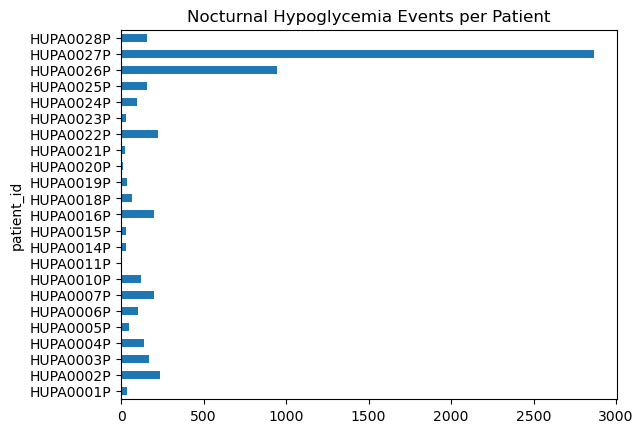

In [138]:
# Step 1: Convert 'time' column to datetime (only if not already)
clean_df['time'] = pd.to_datetime(clean_df['time'], errors='coerce')

night_df = clean_df[clean_df['time'].dt.hour.between(0, 5)]
night_hypo = night_df[night_df['glucose'] < 70].groupby('patient_id').size()
night_hypo.plot(kind='barh', title='Nocturnal Hypoglycemia Events per Patient')

### Q11.Does higher carbohydrate intake require different bolus strategies by time of day?

#### Reasoning: 

<h5>

1. Circadian Variation in Insulin Sensitivity

    - The body’s insulin sensitivity fluctuates throughout the day:
        - Morning: Lower sensitivity (due to cortisol/dawn phenomenon)
        - Afternoon: Highest insulin sensitivity
        - Evening/Night: Moderate to low sensitivity

    - A standard carb-to-insulin ratio (CIR) may overdose or underdose insulin if it doesn’t account for these rhythms.

2. Postprandial Glucose Response Varies by Time

    - Same meal at different times of day can lead to different glucose excursions.
    - Patients may notice higher post-meal spikes in the evening, even with identical carbs and insulin.

3. Digestive Patterns

    - Slower gastric emptying and reduced physical activity in the evening can prolong post-meal glucose elevation.

4. Insulin Resistance Increases Later in the Day

    - Studies show increased hepatic glucose output and reduced peripheral glucose uptake later in the day — requiring higher bolus doses for the same carb intake.

</h5>

#### Key Observations:
<h5>
    
1. Positive Correlation:
    - There is a moderate positive linear trend: as carbohydrate intake increases, bolus insulin also increases. This aligns with physiological expectations (more carbs → more insulin required).

2. Time-of-Day Variations in Bolus Response:
    - The color clusters are not uniformly aligned along the regression line:
        - Afternoon & Night doses (green, blue) seem slightly higher for similar carb ranges.
        - Morning doses (pink) appear lower, even with higher carb intakes — possibly due to conservative dosing or higher insulin resistance.
        - Evening (orange) doses show more dispersion — indicating possible inconsistency in bolus delivery during this time.

3. Outliers & Under-bolusing:

    - A few outlier dots show high carbs but very low bolus (e.g., 100+ grams carbs with ~1 unit insulin) — suggesting missed or insufficient bolusing, which could lead to postprandial hyperglycemia.

</h5>

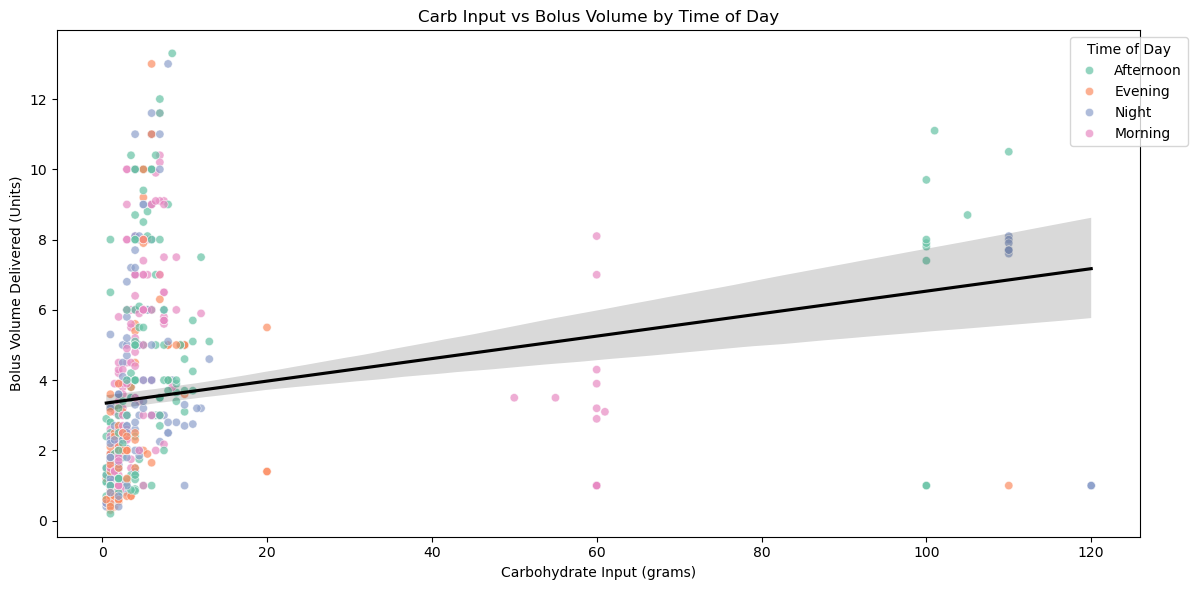

In [147]:
# Ensure time is in datetime format
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Create time-of-day bins
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

merged_df['TimeOfDay'] = merged_df['time'].dt.hour.apply(time_of_day)

# Filter for relevant data
bolus_data = merged_df[
    (merged_df['carb_input'] > 0) & 
    (merged_df['bolus_volume_delivered'] > 0)
].copy()

# Carb intake vs Bolus, split by time of day
plt.figure(figsize=(12, 6))
sns.scatterplot(data=bolus_data, 
                x='carb_input', 
                y='bolus_volume_delivered', 
                hue='TimeOfDay', 
                alpha=0.7, 
                palette='Set2')

sns.regplot(data=bolus_data, 
            x='carb_input', 
            y='bolus_volume_delivered', 
            scatter=False, 
            color='black', 
            line_kws={'label': 'Overall Trend'})

plt.title('Carb Input vs Bolus Volume by Time of Day')
plt.xlabel('Carbohydrate Input (grams)')
plt.ylabel('Bolus Volume Delivered (Units)')
plt.legend(title='Time of Day', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


### Q12.Which patients show highest overall variability?

#### Reasoning: 

<h5>

- High glucose variability increases the risk of both hypoglycemia and hyperglycemia, making glycemic control unpredictable.
- Frequent glucose swings strain the body and complicate insulin dosing, leading to more treatment errors.
- Poor glycemic predictability makes insulin titration less accurate, requiring frequent manual corrections.
- Patients with high variability face more alarms, discomfort, and stress, which can reduce quality of life.
- This burden often leads to treatment fatigue and lower adherence, compromising long-term diabetes management.
</h5>

#### Clinical Flags
<h5>
    
Patients with:

- CV > 36% → Considered high variability
- SD > 50 mg/dL → Needs evaluation

</h5>

#### Recommendations
<h5>

- Patients at the top of each bar chart have the most unstable glucose.
- High CV (>36%) → Suggests need for insulin adjustment or lifestyle intervention.
- High SD → Indicates large swings, even if mean glucose is okay.
</h5>

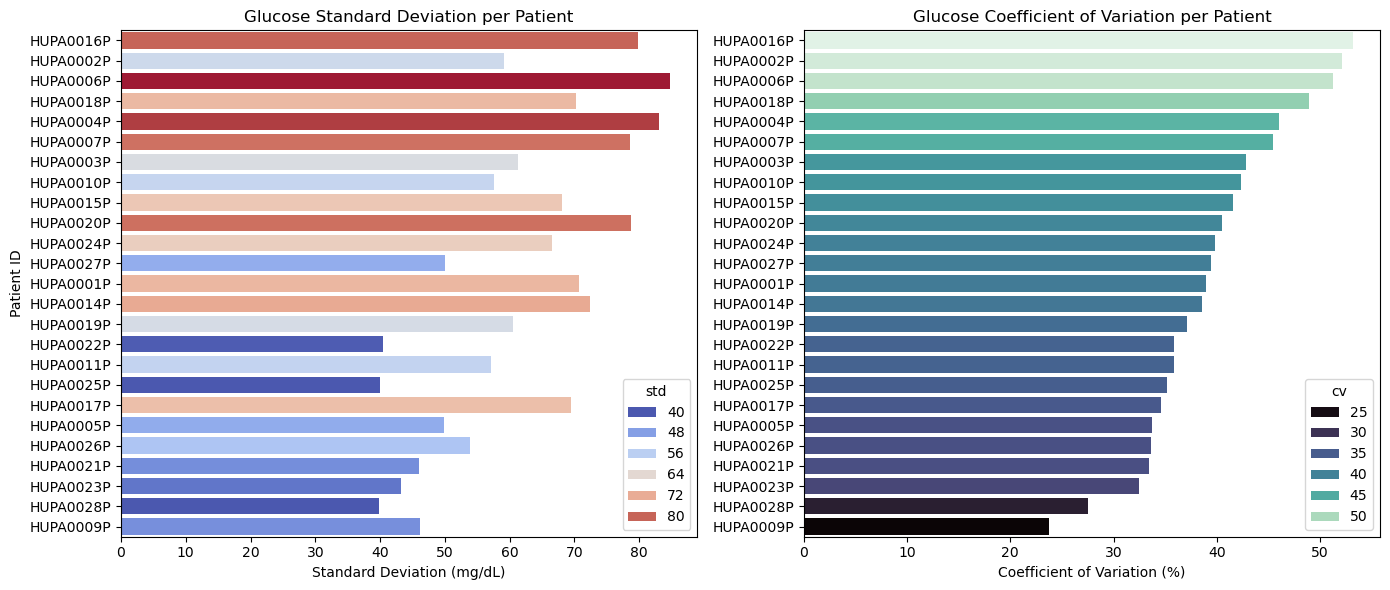

In [240]:
# Step 1: Calculate variability per patient
variability_df = merged_df.groupby('patient_id')['glucose'].agg(['mean', 'std']).reset_index()
variability_df['cv'] = (variability_df['std'] / variability_df['mean']) * 100

# Step 2: Sort by CV or SD
variability_df = variability_df.sort_values(by='cv', ascending=False)

# Step 3: Plot standard deviation and CV side-by-side
plt.figure(figsize=(14, 6))

# Subplot 1: Standard Deviation
plt.subplot(1, 2, 1)
sns.barplot(data=variability_df, x='std', y='patient_id', hue ='std', palette='coolwarm')
plt.title('Glucose Standard Deviation per Patient')
plt.xlabel('Standard Deviation (mg/dL)')
plt.ylabel('Patient ID')

# Subplot 2: Coefficient of Variation
plt.subplot(1, 2, 2)
sns.barplot(data=variability_df, x='cv', y='patient_id', hue ='cv', palette='mako')
plt.title('Glucose Coefficient of Variation per Patient')
plt.xlabel('Coefficient of Variation (%)')
plt.ylabel('')

plt.tight_layout()
plt.show()


### Q13.What time periods pose the highest risk for hyperglycemia or hypoglycemia, and which patient shows the largest glucose spike?

#### 1. Why Analyze Time Windows for Hyper/Hypoglycemia Risk?
#### Reasoning:

<h5>

Glucose varies predictably by time of day due to factors like circadian rhythm, hormonal cycles (e.g., cortisol surge in the morning), and meal/insulin timing. Identifying risk-prone hours helps in personalizing intervention.

Targeted interventions: 
- If hypoglycemia frequently occurs between 2–4 AM (nocturnal hypoglycemia), this could prompt insulin dose adjustment or bedtime snack strategies.

Resource optimization: 
- Time-based alerts (via CGMs or apps) can reduce complications by preemptively warning patients during high-risk periods like early morning (dawn phenomenon) or post-meal spikes.</h5>
#### 2. Why Identify Patient with Highest Glucose Spike?
#### Reasoning:

<h5>

Extreme variability = high risk:
- A patient with the widest glucose range may have poor carb-insulin matching, erratic lifestyle, or unrecognized comorbidities. This person is at higher risk for both hypo- and hyperglycemia.

Personalized intervention: 
- Identifying this outlier supports one-on-one coaching, such as insulin titration, dietary adjustment, or behavioral counseling.

Monitoring priorities: 
- It helps prioritize who needs closer follow-up, more frequent glucose checks, or device calibration.</h5>


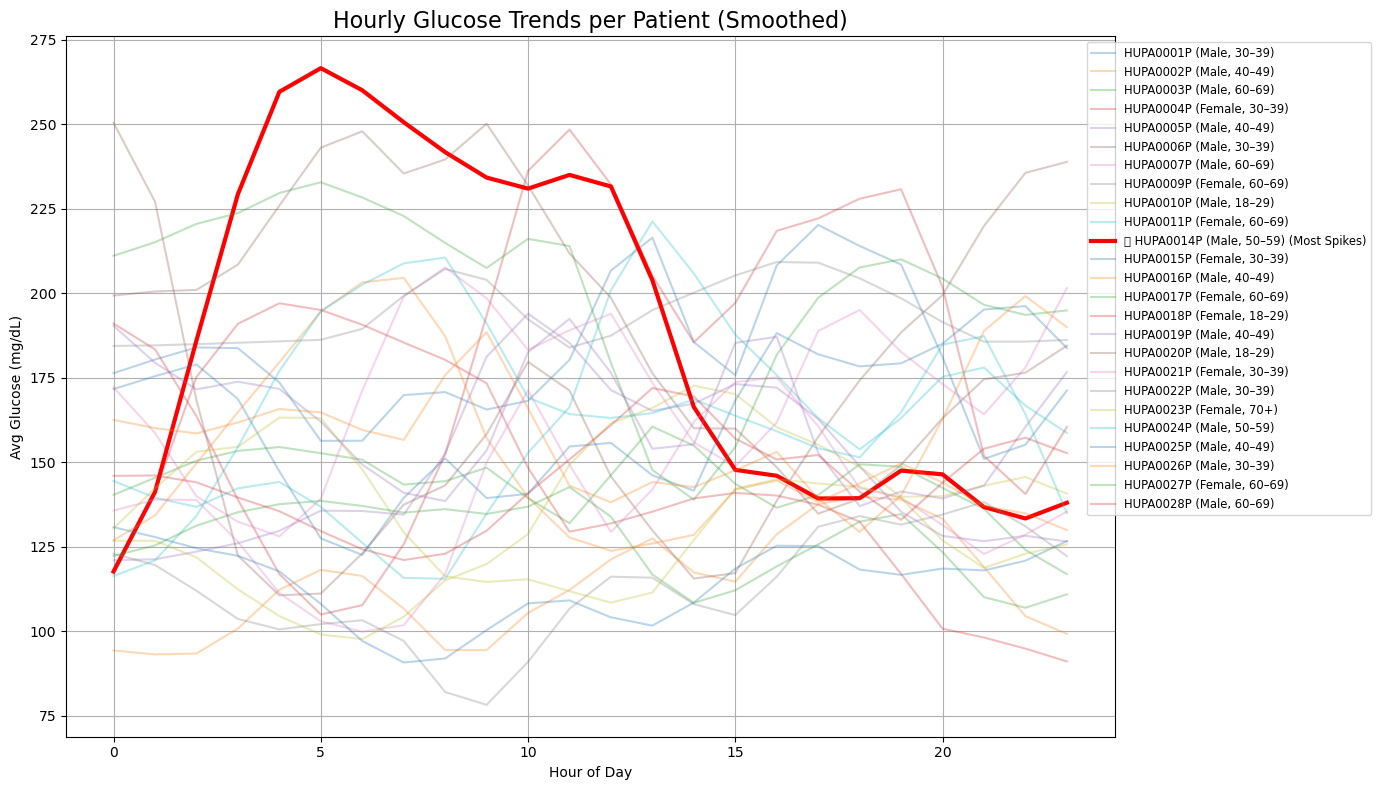

In [182]:
# Ensure datetime format and extract hour
merged_df['time'] = pd.to_datetime(merged_df['time'])
merged_df['hour'] = merged_df['time'].dt.hour

# Categorize age groups
def categorize_age(age):
    if age < 30:
        return '18–29'
    elif age < 40:
        return '30–39'
    elif age < 50:
        return '40–49'
    elif age < 60:
        return '50–59'
    elif age < 70:
        return '60–69'
    else:
        return '70+'

merged_df['age_group'] = merged_df['age'].apply(categorize_age)

# Calculate hourly average glucose
hourly_glucose = merged_df.groupby(['patient_id', 'hour', 'age_group', 'gender'])['glucose'].mean().reset_index()

# Smooth using rolling mean
hourly_glucose['glucose_smooth'] = hourly_glucose.groupby('patient_id')['glucose'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())

# Identify patient with highest glucose spike (range of smoothed glucose)
spike_ranges = hourly_glucose.groupby('patient_id')['glucose_smooth'].agg(lambda x: x.max() - x.min())
highlight_patient = spike_ranges.idxmax()

# Plot
plt.figure(figsize=(14, 8))
unique_patients = hourly_glucose['patient_id'].unique()

for pid in unique_patients:
    subset = hourly_glucose[hourly_glucose['patient_id'] == pid]
    label = f"{pid} ({subset['gender'].iloc[0]}, {subset['age_group'].iloc[0]})"

    if pid == highlight_patient:
        plt.plot(subset['hour'], subset['glucose_smooth'], label=f"🔴 {label} (Most Spikes)", linewidth=3, color='red')
    else:
        plt.plot(subset['hour'], subset['glucose_smooth'], label=label, alpha=0.3)

plt.title('Hourly Glucose Trends per Patient (Smoothed)', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Avg Glucose (mg/dL)')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='small')
plt.tight_layout()
plt.show()
